<a href="https://colab.research.google.com/github/jcandane/numpy_MD/blob/master/Copy_of_fit_md.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Large Scale Fitted-Interpolated-Tabulated MD (FIT-MD)

## Import Stuff

### git clone packages

In [ ]:
!git clone https://github.com/jcandane/CellList
!git clone https://github.com/jcandane/xyz_file_manager
!git clone https://github.com/jcandane/pykry
!pip install numba

fatal: destination path 'CellList' already exists and is not an empty directory.
fatal: destination path 'xyz_file_manager' already exists and is not an empty directory.
fatal: destination path 'pykry' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import Packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from CellList.CellList import celllist, boxbox
from xyz_file_manager.xyz_manager import xyz_reader, Get_xyz_movie
from pykry.fcc import FCClattice

import numba
from   numba import jit, njit

π = np.pi

np.set_printoptions(precision=4, linewidth=200, threshold=2000, suppress=True)

def get_gR(g_r, NN=10):
    """
    coarse grain g(r) by NN
    """

    g_R = g_r.reshape((g_r.shape[0], g_r.shape[1]//NN, NN))
    RR  = np.arange(g_R.shape[1])

    g_R = np.sum(g_R, axis=2)
    g_R[:,0] = 0
    g_R[:,1:] = g_R[:,1:] / (4 * π * RR[1:]**2)
    return RR, g_R

## Initialize System (& compute celllist)

In [ ]:
#Z, R_ix = xyz_reader("Ar_1000.xyz") ## R_ix [Å]
Z, R_ix, m_i = FCClattice(9.9324005, 18, 10, 10, 10, CoM=np.array([0.,0.,0.])) ## a = 9.9324005 a0 (Bohr Radius) for Ar

IJ, indexes, sorted = celllist(R_ix, 24) ## box-size in [å]

print("Number of Atoms: " + str(len(Z)))
print("Number of Boxes: " + str(sorted.shape[0] - 1))
print("Number of Box-Box Interactions: " + str(IJ.size//2) )

Number of Atoms: 4000
Number of Boxes: 27
Number of Box-Box Interactions: 279


## Tabulated Potential

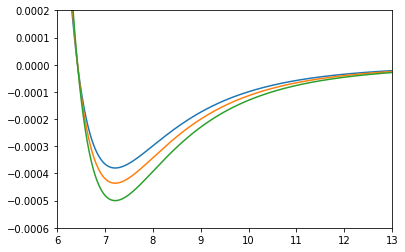

In [ ]:
#### !!! We have to deal with 3 spatial units: Å (Ångström), a0 (Bohr), & u (tabulated units) !!!
## https://simonensemble.github.io/PorousMaterials.jl/dev/force_field/

def get_router(l):
    router  = np.triu( np.arange(0,l,1)[None,:] + np.cumsum( np.roll(np.flip(np.arange(0,l,1)), 1))[:,None] )
    router -= (np.eye(l, dtype=np.int64) - 1) * router.T
    return router


åCu = 100      # å/u  ##
åCÅ = 1.889727  # å/Å  ### 1.8897259885
ÅCu = åCu / åCÅ # Å/u

## http://www.sklogwiki.org/SklogWiki/index.php/Argon
#σ = 6.42507 ## å, in bohr xor 0.34 nm [Rahman 1964] 
#ε = 3.80e-4  ## 120 K  [Rahman 1964]

def get_LJ_potential(Zname, σ, ε, u= 0.01, R_in=2.0,  R_out=180.0): ## u (å)

    ### Lorentz-Berthelot rules
    εε = np.sqrt( ε[:,None]*ε[None,:])
    εε = εε[np.triu_indices(εε.shape[0], k = 0)]
    σσ = (σ[:,None] + σ[None,:]) / 2
    σσ = σσ[np.triu_indices(σσ.shape[0], k = 0)] 

    ### domain in tabulated units
    xi     = np.arange( 0.0,  R_in, u)
    x      = np.arange(R_in, R_out, u) ### these are in Å, units, R_ix / u
    xx     = np.concatenate((xi, x))

    LJE_Ar =  4 * εε[:,None] * ( (σσ[:,None] / x[None,:])**12    - (σσ[:,None] / x[None,:])**6 )
    LJf_Ar = 24 * εε[:,None] * ( 2*σσ[:,None]**12 / x[None,:]**13 - σσ[:,None]**6 / x[None,:]**7 )
    LJE_Ari = np.zeros( (LJE_Ar.shape[0], xi.shape[0]) ) ## 0-part close to atomic-core
    LJf_Ari = np.zeros( (LJf_Ar.shape[0], xi.shape[0]) ) ## 0-part close to atomic-core

    ### package+up
    LJE_Ar = np.concatenate((LJE_Ari, LJE_Ar), axis=1)
    LJf_Ar = np.concatenate((LJf_Ari, LJf_Ar), axis=1)
    E_nAR = np.asarray([LJE_Ar, LJf_Ar])
    return xx, E_nAR, 1/u, get_router(len(Zname)) ### how to set åCu .....????


####################

σ = np.array([6.42507, 6.42507]) ## 
ε = np.array([3.80e-4, 5.00e-4])
Z_consdier = np.array(["Ar", "Ar*"]) 
x, E_nAR, åCu, router = get_LJ_potential(Z_consdier, σ, ε )

plt.plot(x,E_nAR[0,0])
plt.plot(x,E_nAR[0,1])
plt.plot(x,E_nAR[0,2])
plt.xlim([6,13])
plt.ylim([-0.0006,0.0002])
plt.show()

## Compute all boxbox interactions (given celllist & tabulated-potential)

In [ ]:
start = time.time()

AT_i = np.zeros(Z.shape, dtype=int)

E, f_ix, g_r = boxbox(R_ix, AT_i,    IJ, indexes, sorted,     E_nAR, åCu, router) ## this is basically given R_ix, AT_i compute force

print("Energy    = %4.12f a.u." %E)
print("net force = %4.12f a.u." %(np.sum(f_ix)))
print("timer     = %4.6f s" % (time.time()-start))

Energy    = -9.882415315144 a.u.
net force = -0.000000000000 a.u.
timer     = 0.844626 s


In [ ]:
E

-9.88241531514397

## Verlet

100%|██████████| 1000/1000 [09:11<00:00,  1.81it/s]


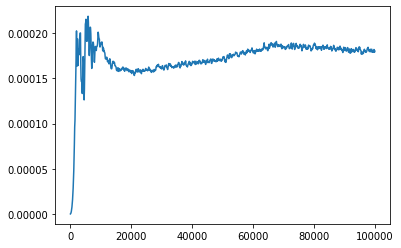

In [ ]:
Z, R_ix, m_i = FCClattice(9.9324005, 18, 12, 10, 9, CoM=np.array([0.,0.,0.]))
AT_i = np.zeros(Z.shape, dtype=int)

IJ, indexes, sorted = celllist(R_ix, 15) ## box-size in [Å]

dT   = 100.
Time = np.arange(0, 100000, dT) ## a.u. 10000 a.u. = 242 fs, 100000 = 2.42 ps

v_ix  = np.zeros(R_ix.shape)
a_ix  = np.zeros(R_ix.shape)

NN    = 10
E_T   = np.zeros(Time.shape)
g_R   = np.zeros((Time.shape[0], E_nAR.shape[1], E_nAR.shape[2]//NN))
for T in tqdm(range(len(Time))):
    R_ix  += v_ix * dT + a_ix * dT*dT/2
    
    U, f_ix, g_r = boxbox(R_ix, AT_i,    IJ, indexes, sorted,     E_nAR, åCu, router)
    A_ix   = f_ix/m_i[:,None]/2 ### !!! or here__ /2???
    
    v_ix  += (A_ix + a_ix) * dT/2
    a_ix   = A_ix

    RR, g_R[T] = get_gR(g_r, NN=NN)
    E_T[T] = np.sum( m_i[:,None] * v_ix**2)/2 + U ## !! why divide KE by 2?? i.e. np.sum( m_i[:,None] * v_ix**2)/2 / 2
    

plt.plot(Time, E_T[0] - E_T)
plt.show()

100%|██████████| 200/200 [01:50<00:00,  1.82it/s]


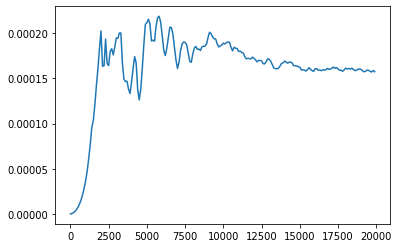

In [ ]:
Z, R_ix, m_i = FCClattice(9.9324005, 18, 12, 10, 9, CoM=np.array([0.,0.,0.]))
AT_i = np.zeros(Z.shape, dtype=int)

IJ, indexes, sorted = celllist(R_ix, 15) ## box-size in [Å]

dT   = 100.
Time = np.arange(0, 20000, dT) ## a.u. 10000 a.u. = 242 fs, 100000 = 2.42 ps

v_ix  = np.zeros(R_ix.shape)
a_ix  = np.zeros(R_ix.shape)

NN    = 10
E_T   = np.zeros(Time.shape)
g_R   = np.zeros((Time.shape[0], E_nAR.shape[1], E_nAR.shape[2]//NN))
for T in tqdm(range(len(Time))):
    R_ix  += v_ix * dT + a_ix * dT*dT/2
    
    U, f_ix, g_r = boxbox(R_ix, AT_i,    IJ, indexes, sorted,     E_nAR, åCu, router)
    A_ix   = f_ix/m_i[:,None]/2 ### !!! or here__ /2???
    
    v_ix  += (A_ix + a_ix) * dT/2
    a_ix   = A_ix

    RR, g_R[T] = get_gR(g_r, NN=NN)
    E_T[T] = np.sum( m_i[:,None] * v_ix**2)/2 + U ## !! why divide KE by 2?? i.e. np.sum( m_i[:,None] * v_ix**2)/2 / 2
    

plt.plot(Time, E_T[0] - E_T)
plt.show()

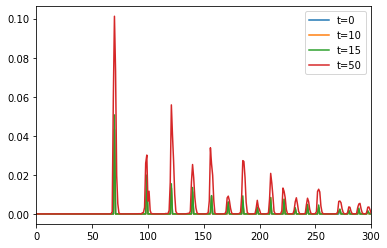

In [ ]:
plt.plot(RR, g_R[0,0], label="t=0")
plt.plot(RR, g_R[10,0], label="t=10")
plt.plot(RR, g_R[15,0], label="t=15")
plt.plot(RR, g_R[190,0], label="t=50")
plt.xlim(0,300)
plt.legend()
plt.show()

## Numba Version

In [ ]:
@njit(nopython=True)
def Numba_BB(R_ix, AT_i,    IJ,     router):
    ##### keep distance in integer and decimal datatype......

    #R_ijx = np.array([ np.outer(R_ix[:,0], R_ix[:,0]), np.outer(R_ix[:,1], R_ix[:,1]), np.outer(R_ix[:,2], R_ix[:,2]) ])

    for i in range(len(IJ)):
        I, J  = IJ[i]
        I_i   = indexes[ sorted[I]:sorted[I+1] ] ## atom indices belonging to box I
        J_j   = indexes[ sorted[J]:sorted[J+1] ] 

        R_ijx = np.empty((len(I_i),len(J_j),3))
        R_ijx[:,:,0] = np.outer(R_ix[I_i,0], R_ix[J_j,0])
        R_ijx[:,:,1] = np.outer(R_ix[I_i,1], R_ix[J_j,1])
        R_ijx[:,:,2] = np.outer(R_ix[I_i,2], R_ix[J_j,2])

        distance = np.sqrt(np.sum(R_ijx**2, axis=2))

        R_ijx[:,:,0]  *= 1/(distance + 1e-12)
        R_ijx[:,:,1]  *= 1/(distance + 1e-12)
        R_ijx[:,:,2]  *= 1/(distance + 1e-12)

        #N, dx    = distance.astype(int), distance-distance.astype(int)
        #distance.astype(int)
        N, dx    = distance.astype(np.int32), distance-np.floor(distance) ### are floor and int type the same???
        
        #### get pair-atom-type
        #AT = router[ np.outer(AT_i[I_i], np.ones(len(J_j), dtype=np.int32)) , np.outer(np.ones(len(I_i), dtype=np.int32), AT_i[J_j]) ]
        ###router[ np.outer(AT_i[I_i], np.ones(len(J_j), dtype=np.int32) ), np.outer(np.ones(len(I_i), dtype=np.int32), AT_i[J_j]) ]
    print(N.shape)
    return None

Numba_BB(R_ix, AT_i,     IJ,    router)

#np.array([ np.outer(R_ix[:,0], R_ix[:,0]), np.outer(R_ix[:,1], R_ix[:,1]), np.outer(R_ix[:,2], R_ix[:,2]) ]).shape
#(R_ix.size)*5 #.repeat(5).shape

/usr/local/lib/python3.7/dist-packages/numba/core/decorators.py:252: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


(14, 14)


In [ ]:
Numba_BB(R_ix, AT_i,     IJ,    router)

(14, 14)


In [ ]:
"""
@jit(nopython=True)
def Numba_boxbox(C_ix, AT_i,    IJ, indexes, sorted,     E_nAR, u, router):
    '''
    GIVEN:  Atom Character;   R_ix (positions), AT_i (Unary Atom-Types)
            Box Neighborhood; IJ (Box Pairs), indexes (over all atoms), sorted (over all boxes)
            Potential;  E_nAR (Potential; n (derivative), A (pair-type), and R (Radial distance))
                        u (unit of potential vs Bohr)
                        router (router for pair-wise atom types)
    GET:    E (energy), f_ix (force), and g_r (pair-correlation)
    '''
    
    #R_ix  = C_ix * åCu ## convert R_ix from Bohr into tabulated units
    R_ix  = C_ix * u ##
    E     = 0.
    f_ix  = np.zeros(R_ix.shape)
    g_r   = np.zeros(E_nAR[0].shape)
    for i in range(len(IJ)):
        I, J  = IJ[i]
        I_i   = indexes[ sorted[I]:sorted[I+1] ] ## atom indices belonging to box I
        J_j   = indexes[ sorted[J]:sorted[J+1] ] ## atom indices belonging to box J

        
        ## displacement/distance calculation
        R_ijx    = np.zeros((len(R_ix), len(R_ix), 3))# R_ix[ I_i, None, : ] - R_ix[ None, J_j, : ]
        distance = np.sqrt(np.sum(R_ijx**2, axis=2)) #np.linalg.norm(R_ijx, axis=2)
        R_ijx   *= 1/(distance[:,:,None] + 1e-10)
        N, dx    = distance.astype(int), distance-distance.astype(int)

        ## get pair-atom-types from unary-atom-types
        AT = router[ np.outer(AT_i[I_i], np.ones(len(J_j), dtype=int)) , np.outer(np.ones(len(I_i), dtype=int), AT_i[J_j]) ]

        ## save pair-correlation, pair-energy, & pair-forces
        g_r[AT, N] += 1
        E          += np.sum( E_nAR[ 0, AT, N ] - E_nAR[ 1, AT, N ] * dx/u )/2 ### use instead analytic derivative?? E_nAR[ 1, AT, N ]??
        #E          += np.sum( E_nAR[ 0, AT, N ] - (E_nAR[ 1, AT, N ]/åCu) * dx )/2
        #E          += np.sum(E_nAR[ 0, AT, N ] + (E_nAR[ 0, AT, N+1 ] - E_nAR[ 0, AT, N ] ) * dx)/2 ### use instead analytic derivative?? E_nAR[ 1, AT, N ]??
        f_ijx       =  (E_nAR[ 1, AT, N ] + (E_nAR[ 1, AT, N+1 ] - E_nAR[ 1, AT, N ] ) * dx)[:,:,None] * R_ijx
        f_ix[I_i]  += np.sum( f_ijx, axis=1)
        f_ix[J_j]  -= np.sum( f_ijx, axis=0)

    return E, f_ix, g_r 

U, f_ix, g_r = Numba_boxbox(R_ix, AT_i,    IJ, indexes, sorted,     E_nAR, åCu, router)

start = time.time()
U, f_ix, g_r = boxbox(R_ix, AT_i,    IJ, indexes, sorted,     E_nAR, åCu, router)
print("Old = %4.6f s"  % (time.time()-start) )

start = time.time()
U, f_ix, g_r = Numba_boxbox(R_ix, AT_i,    IJ, indexes, sorted,     E_nAR, åCu, router)
print("Numba = %4.6f s"  % (time.time()-start) )
"""

'\n@jit(nopython=True)\ndef Numba_boxbox(C_ix, AT_i,    IJ, indexes, sorted,     E_nAR, u, router):\n    \'\'\'\n    GIVEN:  Atom Character;   R_ix (positions), AT_i (Unary Atom-Types)\n            Box Neighborhood; IJ (Box Pairs), indexes (over all atoms), sorted (over all boxes)\n            Potential;  E_nAR (Potential; n (derivative), A (pair-type), and R (Radial distance))\n                        u (unit of potential vs Bohr)\n                        router (router for pair-wise atom types)\n    GET:    E (energy), f_ix (force), and g_r (pair-correlation)\n    \'\'\'\n    \n    #R_ix  = C_ix * åCu ## convert R_ix from Bohr into tabulated units\n    R_ix  = C_ix * u ##\n    E     = 0.\n    f_ix  = np.zeros(R_ix.shape)\n    g_r   = np.zeros(E_nAR[0].shape)\n    for i in range(len(IJ)):\n        I, J  = IJ[i]\n        I_i   = indexes[ sorted[I]:sorted[I+1] ] ## atom indices belonging to box I\n        J_j   = indexes[ sorted[J]:sorted[J+1] ] ## atom indices belonging to box J\n\n   

In [ ]:
'''
@jit(nopython=True)
def Numba_test(C_ix, AT_i,    IJ, indexes, sorted,     E_nAR, u, router):
    """
    GIVEN:  Atom Character;   R_ix (positions), AT_i (Unary Atom-Types)
            Box Neighborhood; IJ (Box Pairs), indexes (over all atoms), sorted (over all boxes)
            Potential;  E_nAR (Potential; n (derivative), A (pair-type), and R (Radial distance))
                        u (unit of potential vs Bohr)
                        router (router for pair-wise atom types)
    GET:    E (energy), f_ix (force), and g_r (pair-correlation)
    """
    
    #R_ix  = C_ix * åCu ## convert R_ix from Bohr into tabulated units
    R_ix  = C_ix * u ##
    E     = 0.
    f_ix  = np.zeros(R_ix.shape)
    g_r   = np.zeros(E_nAR[0].shape)
    for i in range(len(IJ)):
        I, J  = IJ[i]
        I_i   = indexes[ sorted[I]:sorted[I+1] ] ## atom indices belonging to box I
        J_j   = indexes[ sorted[J]:sorted[J+1] ] ## atom indices belonging to box J

        R_ijx  = np.zeros((len(I_i), len(J_j), 3))
        for j in range(len(I_i)):
            for k in range(len(J_j)):
                R_ijx[j,k,:] = R_ix[ I_i[j] ] - R_ix[ J_j[k] ]

        #R_ijx = np.outer( np.ones(len(J_j)), R_ix[ I_i ]) # - np.outer( np.ones(len(I_i)), R_ix[ J_j, : ]).
        
        #print(np.outer( np.ones(len(I_i)), R_ix[ J_j, : ]).shape)

    return E, f_ix, g_r 

U, f_ix, g_r = Numba_test(R_ix, AT_i,    IJ, indexes, sorted,     E_nAR, åCu, router)

start = time.time()
U, f_ix, g_r = Numba_test(R_ix, AT_i,    IJ, indexes, sorted,     E_nAR, åCu, router)
print("Numba = %4.6f s"  % (time.time()-start) )
'''

'\n@jit(nopython=True)\ndef Numba_test(C_ix, AT_i,    IJ, indexes, sorted,     E_nAR, u, router):\n    """\n    GIVEN:  Atom Character;   R_ix (positions), AT_i (Unary Atom-Types)\n            Box Neighborhood; IJ (Box Pairs), indexes (over all atoms), sorted (over all boxes)\n            Potential;  E_nAR (Potential; n (derivative), A (pair-type), and R (Radial distance))\n                        u (unit of potential vs Bohr)\n                        router (router for pair-wise atom types)\n    GET:    E (energy), f_ix (force), and g_r (pair-correlation)\n    """\n    \n    #R_ix  = C_ix * åCu ## convert R_ix from Bohr into tabulated units\n    R_ix  = C_ix * u ##\n    E     = 0.\n    f_ix  = np.zeros(R_ix.shape)\n    g_r   = np.zeros(E_nAR[0].shape)\n    for i in range(len(IJ)):\n        I, J  = IJ[i]\n        I_i   = indexes[ sorted[I]:sorted[I+1] ] ## atom indices belonging to box I\n        J_j   = indexes[ sorted[J]:sorted[J+1] ] ## atom indices belonging to box J\n\n        R_i